In [1]:
%pylab inline
import pandas as pd

import numpy as np
from __future__ import division
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import logging
logger = logging.getLogger()

Populating the interactive namespace from numpy and matplotlib


3 Finding Similar Items
===================
Problem:    
+ "similar": finding sets with a relatively large intersection.    
    - shingling    
    - minhashing    
+ too many pairs of items to test     
    - locality-sentitive hashing
    


### 3.1 Applications of Near-Neighbor Search

The *Jaccard Similarity* of sets $S$ and $T$:
\begin{equation}
SIM(S,T) = \frac{| S \cup T |}{| S \cap T |}
\end{equation}

##### Similar-sets Problem
1. Similar Documents    
In many applicatons, the documents are not identical, yet they share large portions of their text.    
eg: Plagiarism, Mirror Pages, Articles from the Same Source.     
2. Collaborative Filtering(Similar Tastes)    
eg: 
    + Online Purchases    
    + Movie Ratings     
        When data is not binary:           
        - Ignore low-rated customer/movie pairs    
        - "liked" VS "hated"     
        - 1-to-5-starts, put it in a set $n$ times. <= _Jaccard similarity for bags_
            
##### Exercises

In [2]:
#Exercise 3.1.1
logger.setLevel(logging.WARNING)

data = [
    set([1, 2, 3, 4]),
    set([2, 3, 5, 7]),
    set([2, 4, 6]),
]

def Jaccard_similarity_calc(set_a, set_b):
    """calculate the Jaccard similarity of two sets
    
    res = \frac{a \cap b}{a \cup b}
    """
    
    assert isinstance(set_a, set), '{} is not a set'.format(set_a)
    assert isinstance(set_b, set), '{} is not a set'.format(set_b)
    
    logging.debug('a:{}, b:{}'.format(set_a, set_b))
    logging.debug('inter:{}, union:{}'.format(set_a.intersection(set_b), set_a.union(set_b)))
    return len(set_a.intersection(set_b)) / len(set_a.union(set_b))

for comb in list(itertools.combinations(range(3),2)):
    set_a, set_b = data[comb[0]], data[comb[1]]
    print('a:{}, b:{}, SIM:{:.3f}'.format(set_a, set_b, Jaccard_similarity_calc(set_a, set_b)))


a:set([1, 2, 3, 4]), b:set([2, 3, 5, 7]), SIM:0.333
a:set([1, 2, 3, 4]), b:set([2, 4, 6]), SIM:0.400
a:set([2, 3, 5, 7]), b:set([2, 4, 6]), SIM:0.167


In [3]:
#Exercise 3.1.2
logger.setLevel(logging.WARNING)

data = [
    [1, 1, 1, 2],
    [1, 1, 2, 2, 3],
    [1, 2, 3, 4],
]

def Jaccard_bag_similarity_calc(a, b):
    """calculate the Jaccard bag similarity of two sets
    
    see page 76, movie ratings 3.
    intersecton = min(times of element in the two sets)
    union = sum of length of the two sets
    res = intersection / union
    """
    
    from collections import Counter
    
    count_a = Counter(a)
    count_b = Counter(b)
    logging.debug('count_a:{}\n count_b:{}'.format(count_a,count_b))
    
    inter = [min(count_a[x], count_b[x]) for x in count_a if x in count_b]
    logging.debug('intersection:{}'.format(inter))
    
    return sum(inter) / (len(a) + len(b))
    
for comb in list(itertools.combinations(range(3),2)):
    set_a, set_b = data[comb[0]], data[comb[1]]
    print('a:{}, b:{}, JbSIM:{:.3f}'.format(set_a, set_b, Jaccard_bag_similarity_calc(set_a, set_b)))



a:[1, 1, 1, 2], b:[1, 1, 2, 2, 3], JbSIM:0.333
a:[1, 1, 1, 2], b:[1, 2, 3, 4], JbSIM:0.250
a:[1, 1, 2, 2, 3], b:[1, 2, 3, 4], JbSIM:0.333


_exercise 3.1.3_

引理：    
定义
\begin{equation}
    I\{A\} = \begin{cases}
                 1 & \text{if $A$ occurs.} \\
                 0 & \text{otherwise.}
             \end{cases}
\end{equation}
令 $X_A = I\{A\}$，则有 $E[X_A] = \sum I\{A\}P[A] = P[A]$


令 $x_i$ 表示 S 和 T 中有 $i$ 个相同元素，则：
\begin{align}
    E[x_i] & = P[\text{S 和 T 中有 $i$ 个相同元素}] \\
           & = \frac{C_n^i \, C_{n-i}^{2(m-i)}}{C_n^{m} C_n^{m}}
\end{align}

所以
\begin{align}
    E[J] & = \sum_{i=0}^m E[x_i] \, J_i \\
         & = \frac{\sum_{i=0}^m \, C_n^i \, C_{n-i}^{2(m-i)} \, \frac{i}{2(m-i)}}{C_n^{m} C_n^{m}}
\end{align}


`#todo 推导最终式`


### 3.2 Shingling of Documents

**k-shingle**: any substring of length $k$ found within the document.  
+ variation: set -> bag
+ multiple white-space => one white-space
+ choosing k    
    - **large enough** that prob. of **any given shingle** appearing in **any given document** is **low**.    
      k 越大，对相似性要求越高
    - estimate the number of k-shingles as $20^k$, instead of 27 char, 因为各个字符的出现频率并非一致
    - in general,    
      email: k = 5;     
      large documents, such as research articles: k = 9  
+ stop words, such as "and", "you", "to"    
    - ignore them in many application
    - **"stop words + two words"** used as shingle in finding similar **news articles**.
      
**hashing Shingles**: h(shingle) = bucket
+ 9-shingles, then hash to 4 char > 4-shingles

In [4]:
logger.setLevel(logging.WARNING)

def to_alphanumeric_string(s):
    """remove any non-alphanumeric characte in string s.
    """
    import re
    
    s = s.lower()
    s = re.sub('\W', ' ', s)
    logging.debug('after: del special char: {}'.format(s))
    s = re.sub('\s+', ' ', s).strip()
    logging.debug('after: del multiple whitespace: {}'.format(s))
    
    return s

def k_shingle_extrac(document, k):
    """extract all k-shingles from document.
    
    """
    document = to_alphanumeric_string(document)

    assert len(document) >= k, 'k should be less than the length of document'
    
    k_shingles = []
    while len(document) >= k:
        shingle = document[0:k]
        if shingle not in k_shingles:
            k_shingles.append(shingle)
        document = document[1:]
        
    return k_shingles


print('Example 3.3: {}'.format(k_shingle_extrac('abcdabd', 2)))
print('other example: {}'.format(k_shingle_extrac("Hello, I'm So-So.  ", 2)))

Example 3.3: ['ab', 'bc', 'cd', 'da', 'bd']
other example: ['he', 'el', 'll', 'lo', 'o ', ' i', 'i ', ' m', 'm ', ' s', 'so']


##### exercise

In [5]:
#exercise 3.2.1

data = "The most effective way to represent documents as sets, for the purpose of iden- tifying lexically similar documents is to construct from the document the set of short strings that appear within it. "

print('first 10 3-shingles:{}'.format(k_shingle_extrac(data,3)[0:10]))

first 10 3-shingles:['the', 'he ', 'e m', ' mo', 'mos', 'ost', 'st ', 't e', ' ef', 'eff']


In [6]:
#exercise 3.2.2
logger.setLevel(logging.WARNING)

def stopwords_shingles_extract(document, k):
    """extract the stopwords-shingle.
    
    stropwords-shingle = stop-words + k words
    """
    stop_words_list = ['the', 'you', 'to', 'as', 'for', 'of', 'is', 'that', 'it', 'from']
    
    document = to_alphanumeric_string(document)
    document = document.split()
    logging.debug('split:{}'.format(document))
    
    shingles = []
    k = k + 1 #len(shingle) = 1 stop-word + k words
    while(document):
        try:
            logging.debug('check:{}'.format(document[0]))
            if document[0] in stop_words_list:
                shingle = ' '.join(document[0:k])
                logging.debug('hit: {}'.format(shingle))
                
                if shingle not in shingles:
                    shingles.append(shingle)
                    
        except IndexError:
            logging.debug('Index Error: no of char:{}, k: {}'.format(len(document), k))
            k = len(document)
            continue
            
        document = document[1:]
    
    return shingles

print('stop-shingles:{}'.format(stopwords_shingles_extract(data, 2)))
    

stop-shingles:['the most effective', 'to represent documents', 'as sets for', 'for the purpose', 'the purpose of', 'of iden tifying', 'is to construct', 'to construct from', 'from the document', 'the document the', 'the set of', 'of short strings', 'that appear within', 'it']


`#exercise 3.2.3`

k-shingles 最大数量：所有提取的 shingle 均不同    
故从左向右依次取片，有：     
the largest number = n - (k - 1) = n - k + 1


### 3.3 Similarity-Preserving Summaries of Sets

##### Matrix Representation of Sets:  
(r,c) = 1: the element for row r is a member of the set for column c.  
(r,c) = 0: otherwise  

+ matrices are almost always **sparse**

In [7]:
#Example 3.6

logger.setLevel(logging.WARNING)

my_database = ['a', 'b', 'c', 'd', 'e']
my_features_dict = {
    'S1':['a', 'd'],
    'S2':['c'],
    'S3':['b', 'd', 'e'],
    'S4':['a', 'c', 'd']
    }

def matrix_representation_create(database, features_dict):
    """create the matrix representation of one database.
    
    """
    matrix_ = np.zeros((len(database), len(features_dict)), dtype=np.int)
    matrix = pd.DataFrame(matrix_, index=database, columns=sorted(features_dict.keys()))
    
    for feature_name, values in features_dict.iteritems():
        for value in values:
            matrix.loc[value, feature_name] = 1
            
    return matrix
    
    
my_matrix = matrix_representation_create(my_database, my_features_dict)
my_matrix

,S1,S2,S3,S4
a,1,0,0,1
b,0,0,1,0
c,0,1,0,1
d,1,0,1,1
e,0,0,1,0


##### Minhashing

_target_: sets of shingles are large =====> much smaller representations called "**signatures**"

**minhash**
1. pick a permutation of the rows
2. h(columu c) = the row which has the first "1"

In [8]:
#Example 3.7

logger.setLevel(logging.WARNING)

def minhash(matrix, row_orders):
    """calculate the minhash value of matrix according to element permutation in Fig 3.3.
    
    """
    hash_fun_names = ['h{}'.format(i) for i in range(1, len(row_orders)+1)]
    hash_table = pd.DataFrame(np.zeros((len(row_orders), matrix.shape[1])), index=hash_fun_names, columns=matrix.columns)

    for row_order, hash_fun_name in zip(row_orders, hash_fun_names):
        matrix_p = matrix.loc[row_order,:]
        logging.debug('after permutation: \n{}'.format(matrix_p))
    
        for c in matrix_p.columns:
            first_one_index = next((i for i, x in enumerate(matrix_p.loc[:,c]) if x), None)
            hash_table.loc[hash_fun_name, c] = row_order[first_one_index]

    return hash_table


minhash(my_matrix, [['b', 'e', 'a', 'd', 'c']])


,S1,S2,S3,S4
h1,a,c,b,a


**minhash and Jaccard Similarity**: $P[h(S1) = h(S2)] = SIM(S1, S2)$

*Proof*:
rows can be divided into three classes:

+ Type X rows have 1 in both columns (means both S1 and S2 have these features)
+ Type Y rows have 1 in either S1 or S2
+ Type Z rows have 0 in both columns (means both S1 and S2 don't have them)

\begin{align}
    | S1 \cap S2 | & = len(X) \\
    | S1 \cap S2 | & = len(X+Y) \\
    SIM(S1, S2) &= \frac{len(X)}{len(X+Y)}
\end{align}

randomly permute rows, there is at least one colunm whose value is 1:
$$ P[h(S1) = h(S2)] = \frac{len(x)}{len(X+Y)} $$

**minhash signature**:   
use vector $[h_1(S), h_2(S), ... , h_n(S)]$ to represent matrix M    
namely, reduce the dim: columns(M) -----> n

**Computing Minhash Signatures**   
picking a random permutation of large rows and find its hash value both are **time-consuming** ==> simulation

In [9]:
logger.setLevel(logging.WARNING)

my_matrix.index = range(my_matrix.shape[0])
print('matrix:\n{}\n'.format(my_matrix))

h_rows = [
    [1, 2, 3, 4, 0],
    [1, 4, 2, 0, 3]
]

def minhash_by_rows(matrix, row_orders):
    """calculate the minhash value of matrix according to row_permutation in Fig 3.4.
    
    """
    hash_fun_names = ['h{}'.format(i) for i in range(1, len(row_orders)+1)]
    hash_table = pd.DataFrame(np.zeros((len(row_orders), matrix.shape[1])), index=hash_fun_names, columns=matrix.columns)

    for row_order, hash_fun_name in zip(row_orders, hash_fun_names):
        logging.debug('row_order:{}, h:{}'.format(row_order, hash_fun_name))
        matrix_p = matrix.copy()
        matrix_p.index = row_order #new rows permutation
        matrix_p.sort_index(inplace=True) #adjust rows orders
        
        logging.debug('after permutation: \n{}'.format(matrix_p))
    
        for c in matrix_p.columns:
            first_one_index = next((i for i, x in enumerate(matrix_p.loc[:,c]) if x), None)
            hash_table.loc[hash_fun_name, c] = first_one_index

    return hash_table

my_minhash_res = minhash_by_rows(my_matrix, h_rows)
print('minhash: 5dim -> 2dim \n\
       true hash res:\n{}\n'.format(my_minhash_res))

print('Minhashing')

for comb in list(itertools.combinations(range(4),2)):
    s_a, s_b = 'S{}'.format(comb[0]+1), 'S{}'.format(comb[1]+1)
    print('{}-{}'.format(s_a, s_b)),
    
    set_a, set_b = set(my_minhash_res.iloc[:,comb[0]]), set(my_minhash_res.iloc[:,comb[1]])
    print('minhash:{:.3f}'.format(Jaccard_similarity_calc(set_a, set_b))),
    print('true SIM:{:.3f}'.format(Jaccard_similarity_calc(set(my_features_dict[s_a]), set(my_features_dict[s_b]))))




matrix:
   S1  S2  S3  S4
0   1   0   0   1
1   0   0   1   0
2   0   1   0   1
3   1   0   1   1
4   0   0   1   0

minhash: 5dim -> 2dim 
       true hash res:
    S1  S2  S3  S4
h1   1   3   0   1
h2   0   2   0   0

Minhashing
S1-S2 minhash:0.000 true SIM:0.000
S1-S3 minhash:0.500 true SIM:0.250
S1-S4 minhash:1.000 true SIM:0.667
S2-S3 minhash:0.000 true SIM:0.000
S2-S4 minhash:0.000 true SIM:0.333
S3-S4 minhash:0.500 true SIM:0.200


对 $M$ 中的所有行做一次随机组合得到 $\bar{M}$，非常耗时。    
解决方法是不直接操作矩阵 $M$，而是分两步操作：

1) 选择合适的哈希函数生成行号序列来模拟随机排列结果，如上个代码区块中 `h_rows` 即可用 $h_1(x) = (x + 1) \% 5$ 和 $h_2(x) = (3x + 1) \% 5$ 生成对应的行号

In [10]:
def add_hash_func(a, b, c):
    return lambda x: (a*x + b) % c

h_funcs = [
    add_hash_func(1, 1, 5),
    add_hash_func(3, 1, 5)
    ]

h_rows = []
for h_func in h_funcs:
    h_rows.append(map(h_func, range(5)))
    
print('h_rows:{}'.format(h_rows))

h_rows:[[1, 2, 3, 4, 0], [1, 4, 2, 0, 3]]


2) 再按照行号重新对行排序，生成新矩阵 $\bar{M}$     
但第 2 步排序仍然需要操作矩阵，见函数 `minhash_by_rows` 中的语句 `matrix_p.sort_index(inplace=True)`。

In [11]:
#Fig 3.4

df_matrix = my_matrix
df_h_rows = pd.DataFrame(np.array(h_rows).T)
df_h_rows.columns = ['h{}'.format(x+1) for x in df_h_rows.columns]

print('Hash functions computed for the matrix:\n{}\n'.format(pd.concat([df_matrix, df_h_rows], axis=1)))
print('signature matrix\n(SIG):\n{}'.format(my_minhash_res))

Hash functions computed for the matrix:
   S1  S2  S3  S4  h1  h2
0   1   0   0   1   1   1
1   0   0   1   0   2   4
2   0   1   0   1   3   2
3   1   0   1   1   4   0
4   0   0   1   0   0   3

signature matrix
(SIG):
    S1  S2  S3  S4
h1   1   3   0   1
h2   0   2   0   0


Let SIG(i,c) be the element of the signature matrix for the ith hash function and column c.

替代方法是借助思路：$ SIG(i,c) = min(h_i(S_c=1)) $    
即对于 $h_i(S_c)$ 值来说，它只可能是 “1” 对应的行号，而第一个 “1” 肯定是最小的行号。

比如，我们想得到 SIG(1,1) 的值，  
$S1 = [1, 0, 0, 1, 0]^T$，对应的 $h1 = [1, 2, 3, 4, 0]^T$，    
SIG(1,1) 只能取 “1” 的行号，即 1 或 4，    
又 SIG 是第一个遇到的 “1”，所以 SIG(1,1) 肯定是 1。

**思路总结**：    
我们对每个 SIG(i,c) 都可以通过遍历 $S_i$ 中 "1" 位置，取出 $h_c$ 中相应位置的行号，行号中最小的值就是解。

而这个思路是可以并行化处理的，有两种方法：

1. 列遍历：即从左至右遍历 $S_i$ 得到 "1" 位置时，我们可以据此取出所有 $h_c$ 相应的行号，分别取最小。
2. 行遍历：书中 Example3.8 例子，从上往下遍历，逐行比较。    
   步骤如下：    
   1. Compute $h_1(r), h_2(r), ... , h_n(r)$.
   2. For each column $c$ do the following:
       + If $c$ has $0$ in row $r$, do nothing
       + else, if $c$ has $1$ in row $r$,   
       for each $i = 1,2, ..., n$,     
       $SIG(i,c) = min \left( SIG(i,c), \, h_i(r) \right)$
       
行遍历的方法，粗略想，计算量应该更少。     
`#todo: 验证计算量`

In [12]:
#Example 3.8

logger.setLevel(logging.WARNING)

def minhash_signatures_calc(df_M, hash_funcs, nagging=False):
    """computing minhash signatures by the way in Example 3.8.
    
    """
    logging.debug('data matrix:\n{}\n'.format(df_M))

    h = []
    
    for hash_func in hash_funcs:
        h.append(map(hash_func, range(df_M.shape[0])))
        
    df_h = pd.DataFrame(np.array(h).T)
    df_h.columns = ['h{}'.format(x+1) for x in df_h.columns]
    logging.debug('hash matrix:\n{}\n'.format(df_h))
    
    if nagging:
        print('hash matrix:\n{}\n'.format(pd.concat([df_matrix, df_h], axis=1)))
    
    df_signatures = pd.DataFrame(np.ones((df_h.shape[1], df_M.shape[1]))*np.inf, index=df_h.columns, columns=df_M.columns)
    logging.debug('signatures matrix:\ninit\n{}\n'.format(df_signatures))

    for r in df_M.index:
        for c in df_h.columns:
            r_1_loc = df_M.loc[r,:] == 1
            logging.debug('r:{}, c:{}, 1 loc:\n{}\n'.format(r,c, r_1_loc))
            
            sig_c = df_signatures.loc[c,:]
            line_bigger_loc = sig_c > df_h.loc[r, c]
            logging.debug('bigger row loc:\n{}\n'.format(line_bigger_loc))
            
            sig_c[line_bigger_loc & r_1_loc] = df_h.loc[r, c]
            logging.debug('modified:\n{}\n'.format(sig_c))
            
            df_signatures.loc[c,:] = sig_c
        if nagging:
            print('row:{},\n signature matrix:\n{}\n'.format(r, df_signatures))
            
    return df_signatures

minhash_signatures_calc(df_matrix, h_funcs, nagging=True)

hash matrix:
   S1  S2  S3  S4  h1  h2
0   1   0   0   1   1   1
1   0   0   1   0   2   4
2   0   1   0   1   3   2
3   1   0   1   1   4   0
4   0   0   1   0   0   3

row:0,
 signature matrix:
    S1   S2   S3  S4
h1   1  inf  inf   1
h2   1  inf  inf   1

row:1,
 signature matrix:
    S1   S2  S3  S4
h1   1  inf   2   1
h2   1  inf   4   1

row:2,
 signature matrix:
    S1  S2  S3  S4
h1   1   3   2   1
h2   1   2   4   1

row:3,
 signature matrix:
    S1  S2  S3  S4
h1   1   3   2   1
h2   0   2   0   0

row:4,
 signature matrix:
    S1  S2  S3  S4
h1   1   3   0   1
h2   0   2   0   0



,S1,S2,S3,S4
h1,1,3,0,1
h2,0,2,0,0


##### exercise 3.3

In [13]:
#exercise 3.3.1

#generate 120 permutations
h_rows = list(itertools.permutations(range(5),5))
my_minhash_res = minhash_by_rows(my_matrix, h_rows)

for comb in list(itertools.combinations(range(4),2)):
    s_a, s_b = 'S{}'.format(comb[0]+1), 'S{}'.format(comb[1]+1)
    print('{}-{}'.format(s_a, s_b)),
    #calc Jaccard similarity
    print('true SIM:{:.3f}'.format(Jaccard_similarity_calc(set(my_features_dict[s_a]), set(my_features_dict[s_b])))),
    #calc the fraction of the 120 permutations in which the value is same
    print('fraction:{:.3f}'.format(sum(my_minhash_res.loc[:,s_a] == my_minhash_res.loc[:,s_b])/120))


S1-S2 true SIM:0.000 fraction:0.000
S1-S3 true SIM:0.250 fraction:0.250
S1-S4 true SIM:0.667 fraction:0.667
S2-S3 true SIM:0.000 fraction:0.000
S2-S4 true SIM:0.333 fraction:0.333
S3-S4 true SIM:0.200 fraction:0.200


In [14]:
#exercise 3.3.2
h_funcs[2:4] = [
    add_hash_func(2, 4, 5),
    add_hash_func(3, -1, 5)
]

minhash_signatures_calc(df_matrix, h_funcs, nagging=True)

hash matrix:
   S1  S2  S3  S4  h1  h2  h3  h4
0   1   0   0   1   1   1   4   4
1   0   0   1   0   2   4   1   2
2   0   1   0   1   3   2   3   0
3   1   0   1   1   4   0   0   3
4   0   0   1   0   0   3   2   1

row:0,
 signature matrix:
    S1   S2   S3  S4
h1   1  inf  inf   1
h2   1  inf  inf   1
h3   4  inf  inf   4
h4   4  inf  inf   4

row:1,
 signature matrix:
    S1   S2  S3  S4
h1   1  inf   2   1
h2   1  inf   4   1
h3   4  inf   1   4
h4   4  inf   2   4

row:2,
 signature matrix:
    S1  S2  S3  S4
h1   1   3   2   1
h2   1   2   4   1
h3   4   3   1   3
h4   4   0   2   0

row:3,
 signature matrix:
    S1  S2  S3  S4
h1   1   3   2   1
h2   0   2   0   0
h3   0   3   0   0
h4   3   0   2   0

row:4,
 signature matrix:
    S1  S2  S3  S4
h1   1   3   0   1
h2   0   2   0   0
h3   0   3   0   0
h4   3   0   1   0



,S1,S2,S3,S4
h1,1,3,0,1
h2,0,2,0,0
h3,0,3,0,0
h4,3,0,1,0


In [15]:
#exercise 3.3.3

my_database = range(6)
my_features_dict = {
    'S1':[2, 5],
    'S2':[0, 1],
    'S3':[3, 4],
    'S4':[0, 2, 4]
    }

df_fig_3_5 = matrix_representation_create(my_database, my_features_dict)
print('Fig 3.5:\n{}\n'.format(df_fig_3_5))


#(a)
h_funcs = [
    add_hash_func(2, 1, 6),
    add_hash_func(3, 2, 6),
    add_hash_func(5, 2, 6)
]
df_matrix = df_fig_3_5
my_minhash_res = minhash_signatures_calc(df_matrix, h_funcs, nagging=True)
my_minhash_res

Fig 3.5:
   S1  S2  S3  S4
0   0   1   0   1
1   0   1   0   0
2   1   0   0   1
3   0   0   1   0
4   0   0   1   1
5   1   0   0   0

hash matrix:
   S1  S2  S3  S4  h1  h2  h3
0   0   1   0   1   1   2   2
1   0   1   0   0   3   5   1
2   1   0   0   1   5   2   0
3   0   0   1   0   1   5   5
4   0   0   1   1   3   2   4
5   1   0   0   0   5   5   3

row:0,
 signature matrix:
     S1  S2   S3  S4
h1  inf   1  inf   1
h2  inf   2  inf   2
h3  inf   2  inf   2

row:1,
 signature matrix:
     S1  S2   S3  S4
h1  inf   1  inf   1
h2  inf   2  inf   2
h3  inf   1  inf   2

row:2,
 signature matrix:
    S1  S2   S3  S4
h1   5   1  inf   1
h2   2   2  inf   2
h3   0   1  inf   0

row:3,
 signature matrix:
    S1  S2  S3  S4
h1   5   1   1   1
h2   2   2   5   2
h3   0   1   5   0

row:4,
 signature matrix:
    S1  S2  S3  S4
h1   5   1   1   1
h2   2   2   2   2
h3   0   1   4   0

row:5,
 signature matrix:
    S1  S2  S3  S4
h1   5   1   1   1
h2   2   2   2   2
h3   0   1   4   0



,S1,S2,S3,S4
h1,5,1,1,1
h2,2,2,2,2
h3,0,1,4,0


In [16]:
#(b) h_3 is a true permutation.

#(c)

for comb in list(itertools.combinations(range(4),2)):
    s_a, s_b = 'S{}'.format(comb[0]+1), 'S{}'.format(comb[1]+1)
    print('{}-{}'.format(s_a, s_b)),
    
    set_a, set_b = set(my_minhash_res.iloc[:,comb[0]]), set(my_minhash_res.iloc[:,comb[1]])
    print('minhash:{:.3f}'.format(Jaccard_similarity_calc(set_a, set_b))),
    print('true SIM:{:.3f}'.format(Jaccard_similarity_calc(set(my_features_dict[s_a]), set(my_features_dict[s_b]))))


S1-S2 minhash:0.250 true SIM:0.000
S1-S3 minhash:0.200 true SIM:0.000
S1-S4 minhash:0.500 true SIM:0.250
S2-S3 minhash:0.667 true SIM:0.000
S2-S4 minhash:0.667 true SIM:0.250
S3-S4 minhash:0.500 true SIM:0.250


`#exercise 3.3.4`   
不是很明白意思，大概想法是：    
从 $n$ 中抽取 $m$ 个元素集合 $S$ 和 $T$，则从 $S$ 和 $T$ 中各抽一次，元素相同的概率是多少？

`#exercise 3.3.5`   
元素相同的概率是 0

### 3.4 Locality-Sensitive Hashing for Documents

minhash 降低了维度，但计算耗时问题仍然存在：  
令样本集有 $k$ 个元素，两两比较次数是 $C_k^2 = O(k^2)$。    
若 $k$ 很大，则比较次数成乘方倍增长。

解决思路：   
1. 并行处理    
2. 只比较可能相似的样本    
   often we want only the most similar pairs or all paris that are above some lower bound in similarity.     
   ----> Locality-sensitive hasing (LSH) or near-neighbor search.
   
**LSH**:   
"hash" items several times, in such a way: $$P[\text{similar items in the same bucket}] >> P[\text{dissimilar ...}]$$

candidate pair: any pair hashed to the same bucket.   
false postive: dissimilar items in the candidate pair.    
false negtive: similar items NOT in the cnadidate pair.

if we have minhash signatures for the items, an effective way to choose the hashings is:    
1. divide the signature matrix into $b$ bands consisting of $r$ rows each.
2. for each band $b_i$, hash each vector in $b_i$   
   hash function $h$: same vectors -> same bucket
   
也就是说，将两个样本向量分割，只要有一个节点哈希到一起，就认为是候选对。

注意，统计的是每个节点各自哈希的情况，所以每个节点使用相同的哈希函数，但使用独立的哈希表存储中间结果。如下图：

matrix | --> | hash table
:-------:|:------:|:------------:
band 1 | h(v) | hash_talbe_1
band 2 | h(v) | hash_talbe_2
....   | h(v) | ....


**Analysis** the probabilty of two pairs to become a candidate pairs:   
Given the pairs $s_a$ and $s_b$ have Jaccard similarity $s$, we use $b$ bands of $r$ row each to split their signature matrix $M_a$ and $M_b$.    
1. $\forall \, i^{th} \, \text{row}, \, prob_{rowY} = P[M_a[i,:] == M_b[i,:]] = \text{Jaccard similarity} = s$
2. the possibility that one band($r$ row) is the same is: $$prob_{bandY} = prob_{rowY}^r = s^r$$
   .......................................not the same is: $$prob_{bandN} = 1 - prob_{bandY} = 1 - s^r$$
3. $s_a$ and $s_b$ are totally different: $$prob_{pairN} = prob_{bandN}^b = (1 - s^r)^b$$
   $s_a$ and $_b$ **at least agree in one band**: $$prob_{pairY} = 1 - prob_{pairN} = 1 - (1 - s^r)^b$$
   

**threshold**: the value of $s$ at which the probability of becoming a candidate is 1/2.    
namely, $1 - (1 - s^r)^b = \frac{1}{2}$, the solution $s \approx (1/b)^{1/r}$

[(0.20000000000000001, 0.0063805813047682625),
 (0.30000000000000004, 0.047494259124971183),
 (0.40000000000000008, 0.18604955214914409),
 (0.50000000000000011, 0.47005071531687648),
 (0.60000000000000009, 0.80190245383822212),
 (0.70000000000000018, 0.97478054418804061),
 (0.80000000000000027, 0.99964394210947927)]

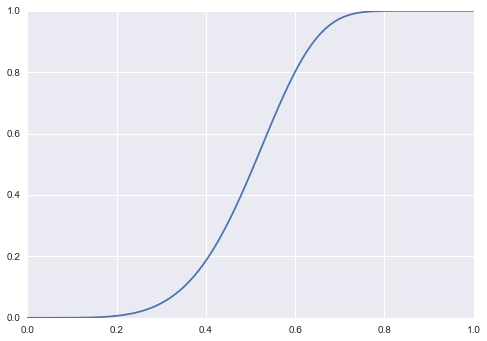

In [17]:
#Example 3.11

b = 20
r = 5
s = np.linspace(0, 1, 100)

def p(s, r, b):
    return 1 - (1 - s**r)**b

plot(s,p(s, r, b))

s = np.arange(0.2, 0.9, 0.1)

zip(s, p(s, r, b))

if we consider two documents with 80% similarity, then their false negative is $1 - 0.99964... \approx 0.00035$, which means that only roughly 1 in 3000 pairs that are as high as 80% similar will fail to become a candidate pair.

##### Combining the Techniques
整合前面讲过的方法，找到相似文本的方法如下：

1. k-shingles    
   [opt] hash k-shignles to shorter bucket numbers   

2. Sort the document-shigles pairs    
   不用生成完成的矩阵，而是依据 shingles 顺序后面用到时逐行生成（节省内存）
   
3. Pick n, compute the minhash signatures by feed the sorted list line by line     
   逐行遍历
   
4. Choose a threshold $t$    
   $t \approx (1/b)^{1/r}$ and $n = b \times n$ to determine appropriate $b, n$.
   
5. Construct candidate pairs using LSH

6. Examine each candidate pair's signatures, $SIM > t$?

7. [opt] check document themselve

`#todo: 找个例子，代码实现`

##### exercise 3.4
`#maybe:`

`#exercise 3.4.3`

`#exercise 3.4.4`

### 3.5 Distance Measures

**LSH** 本身的意义：   
就是为一个特定的距离 $l$，找到合适的哈希函数 $h$ 来实现 "S" 曲线的效果：   
即此距离下越近，哈希到同一区块的可能性越高。

这章介绍距离，为下一章找哈希函数打基础。   

##### 距离的定义

定义集合 $X$ 上的度量為一函數距离 $d: X \times X \to \mathbf{R}$    
对于 $\forall x, y, z \in X$，应满足：

1. 正定性    
$d(x, y) \ge 0$    
$d(x, y) = 0$ if and only if $x = y$

2. 交换性    
$d(x, y) = d(y, x)$

3. 三角不等式    
$d(x, y) \le d(x, z) + d(z, y)$


##### 几种距离
1. Euclidean Distance: $\| \cdot \|_2$    
   $L_r\text{-norm} = (\sum \| \cdot \|_1^r)^{1/r}$    
   $L_\infty\text{-norm} = max(\| \cdot \|_1)$
   
2. Jaccard Distance: $d(x, y) = 1 - SIM(x, y)$

3. Cosine Distance: $d(x, y) = \frac{x \cdot y}{\|x\|_2 + \|y\|_2}$

4. Edit Distance:      
   Given $x = x_1 x_2 ...$, $y = y_1 y_2 ...$.   
   $d(x, y)$ is the smallest number of insertion and deletion of single char($x \to y$).

   $d(x, y) = len(x) + len(y) - 2 LCS(x, y)$    
   LCS is the longest common subsequence of $x$ and $y$.

5. Hamming Distance: $d(x, y) = sum( \, diff(x, y) \,)$



### 3.6 The Theory of Locality-Sensitive Function

对于每种距离定义，需要找到合适的哈希函数使其满足 $P-S$ 是 "S" 型曲线（越相似，概率越高）。

a family of functions should statify 3 conditions:

1. $P[\text{close pairs become candidate pairs}] > P[\text{dissimilar pairs...}]$

2. 